# *Studying and mitigating the effects of data drifts on ML model performance*
## Example notebook:  Recalibration strategy for multiple endpoints, evaluate using boxplots

This notebook is part of the supporting information to the manuscript entitled: *Studying and mitigating the effects of data drifts on ML model performance at the example of chemical toxicity data*
* Authors: A. Morger, M. Garcia de Lomana, U. Norinder, F. Svensson, J. Kirchmair, M. Mathea, A. Volkamer
* Last updated: September 2021

This notebook illustrates 
* How to build and evaluate models for several endpoints at a time: For each endpoint, ACP's are trained without and with updating the calibration set. In this example, the calibration set is even updated twice. 
* How the predictions could be evaluated using boxplots: For comparison over all endpoints, the balanced validity, balanced efficiency and balanced accuracy are calculated and plotted.

## Import packages and modules

In [1]:
import pandas as pd
import numpy as np
import sys
import math
import tarfile

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor

In [4]:
from nonconformist.nc import InverseProbabilityErrFunc, NcFactory

In [5]:
from continuous_calibration import (
StratifiedRatioSampler, BalancedStratifiedRatioSampler, CrossValidationSampler, InductiveConformalPredictor, 
    ContinuousCalibrationAggregatedConformalPredictor, CrossValidator
)
from continuous_calibration_helper_functions import (
    boxplot_val_eff_acc_quer, draw_scatter_plot_more_datasets, format_dataset_dict
)

## Define paths and parameters

Note that due to the size of the collected ChEMBL datasets containing the precalculated ChemBio descriptors, they were uploaded to [Zenodo](https://zenodo.org/record/5167636). Please download them first and copy the compressed file to the `data` folder to continue with the following code.

In [6]:
# Dataset with all 12 ChEMBL endpoints. 
data_path = "../data/chembl_chembio_descriptors.tar.bz2"

In [7]:
# Dataset defining the splits by publication year into the CP subsets.
# Contains information for all 12 endpoints.
time_split_threshold_path = "../data/data_size_chembio_chembl.csv"

Select endpoints

In [8]:
# Note: Running the calculations for all endpoints takes time. If you only want to test the notebook,
# it is recommended to only select a few endpoints (i.e. comment the rest out)
endpoint_dict = {
    "CHEMBL203": ["EGFR erbB1", "Epidermal growth factor receptor erbB1"],
    "CHEMBL279": ["VEGFR 2", "Vascular endothelial growth factor receptor 2"],
    "CHEMBL340": ["Cytochrome P450 3A4"],
    "CHEMBL5763": ["Cholinesterase"],
    "CHEMBL206": ["Estrogen receptor alpha"],
    "CHEMBL2039": ["Monoamine oxidase B"],
    "CHEMBL4078": ["Acetylcholinesterase"],
    "CHEMBL220": ["Acetylcholinesterase"],
    "CHEMBL230": ["Cyclooxygenase-2"],
    "CHEMBL240": ["HERG"],    
    "CHEMBL222": ["Norepinephrine transporter"],
    "CHEMBL228": ["Serotonin transporter"],
    
    
    
    
#     "CHEMBL279": ["VEGFR 2", "Vascular endothelial growth factor receptor 2"],
#     "CHEMBL220": ["Acetylcholinesterase"],
#     "CHEMBL4078": ["Acetylcholinesterase"],
#     "CHEMBL5763": ["Cholinesterase"],
#     "CHEMBL203": ["EGFR erbB1", "Epidermal growth factor receptor erbB1"],
#     "CHEMBL206": ["Estrogen receptor alpha"],
#     "CHEMBL222": ["Norepinephrine transporter"],
#     "CHEMBL228": ["Serotonin transporter"],
#     "CHEMBL230": ["Cyclooxygenase-2"],
#     "CHEMBL340": ["Cytochrome P450 3A4"],
#     "CHEMBL240": ["HERG"],
#     "CHEMBL2039": ["Monoamine oxidase B"],
}

endpoints = list(endpoint_dict.keys())
print(endpoints)

['CHEMBL203', 'CHEMBL279', 'CHEMBL340', 'CHEMBL5763', 'CHEMBL206', 'CHEMBL2039', 'CHEMBL4078', 'CHEMBL220', 'CHEMBL230', 'CHEMBL240', 'CHEMBL222', 'CHEMBL228']


Define machine learning parameters.

Note that the calculations take time and computational resources. If you just want to try out the notebook, we recommend using the small values provided. To get the same plots as in the manuscript (maybe small deviations due to random splitting and random forest), replace them by the larger values (as provided in the comments).

In [9]:
n_trees = 20 # 500
n_folds_acp = 3 # 20

Define boxplot parameters

In [10]:
# Strategies to compare
strategies = ["cv_original", "original", "update1", "update2"]
# Evaluation measures to display in boxplot
evaluation_measures = ["validity_bal", "efficiency_bal", "accuracy_bal"]
significance_level = 0.2

## Define helper functions

In [11]:
def load_data_per_endpoint(endpoint_df, endpoint_id):
    """
    Load endpoint dataframe and return arrays holding labels, descriptors and publication years for the data set.
    
    Parameters
    ----------
    endpoint_df : pd dataframe
        Dataframe containing descripor, label, and measured year information per compound.
    endpoint_id : string
        ChEMBL Id of the endpoint.
    
    Returns
    -------
    X: np array
        Descriptors per compound
    y: np array
        Labels per compoound
    years: np array
        Publication year per compound
    
    """
       
    # Drop compound without publication year
    endpoint_df.dropna(subset=["year"], inplace=True)
    # Define labels for the ML experiment
    y = endpoint_df[f"{endpoint_id}_bioactivity"].values
    # Define feature columns from the ChemBio descriptors, i.e. descelect 
    # other columns, which are not p-values and chemical descriptors
    columns = [
            col
            for col in endpoint_df.columns
            if (not col.startswith("Toxicity"))  # Exclude in vivo labels used for p-values
            and (col != f"{endpoint_id}_bioactivity")  # Exclude ChEMBL bioactivity labels
            and (col != "SMILES (Canonical)")  # Exclude canonical smiles
            and (col != "smiles")  # Exclude smiles
            and (col != "year")  # Exclude publication year
            and (col != "molecule_chembl_id")  # Exclude molecule ChEMBL id
        ]
    # Define descriptors
    X = endpoint_df[columns].values
    # Define array with publication years
    years = endpoint_df["year"].values
    return X, y, years

In [12]:
def split_data_per_endpoint(X, y, years, splits_df, endpoint_id):
    """
    Split dataset into training, update1, update2 and holdout set based on publication year.
    
    Parameters
    ----------
    X: np array
        Descriptors per compound
    y: np array
        Labels per compoound
    years: np array
        Publication year per compound
    splits_df: pd dataframe
        Splitting year thresholds
    endpoint_id : string
        ChEMBL Id of the endpoint.
    
    Returns
    -------
    X_train, X_update1, X_update2, X_holdout: np arrays
        Descriptors per compoundper split
    y_train, y_update1, y_update2, y_holdout: np arrays
        Labels per compoound per split

    """
    
    # Collect the year thresholds to split the data
    thresholds = splits_df["train_thresh"][endpoint_id], splits_df["update1_thresh"][endpoint_id], splits_df["update2_thresh"][endpoint_id]
    
    # Get the indices that define how to split the data
    mask_train = years <= thresholds[0]
    mask_update1 = (years > thresholds[0]) & (years <= thresholds[1])
    mask_update2 = (years > thresholds[1]) & (years <= thresholds[2])
    mask_holdout = years > thresholds[2]
    
    # Split the data
    X_train, y_train = X[mask_train], y[mask_train]
    X_update1, y_update1 = X[mask_update1], y[mask_update1]
    X_update2, y_update2 = X[mask_update2], y[mask_update2]
    X_holdout, y_holdout = X[mask_holdout], y[mask_holdout]
    
    return X_train, X_update1, X_update2, X_holdout, y_train, y_update1, y_update2, y_holdout

In [13]:
def prepare_rf_acp(n_rf_trees, train_split_acp):
    """
    Prepare and return an aggregated conformal predictor (ACP).
    Default parameteres: random forest classifier, inverse probability error function, mondrian condition.
    
    Parameters
    ----------
    n_rf_trees: int
        Number of trees in the forest.
    train_split_acp: int
        Training data split for ACP (default: 70% proper training and 30% calibration set)
     
    Returns
    -------
    acp: continuous_calibration ACP
        Initialized ACP object
        
    """
    
    # Define ML classifier (random forest)
    clf = RandomForestClassifier(n_estimators=n_rf_trees)
    # Define error function for conformal prediction (inverse probability error function)
    error_function = InverseProbabilityErrFunc()
    # Define nonconformity function object
    nc = NcFactory.create_nc(clf, err_func=error_function, normalizer_model=None)
    # Build inductive conformal predictor (mondrian condition)
    icp = InductiveConformalPredictor(nc_function=nc, condition=(lambda instance: instance[1]), 
                                      smoothing=False)
    # Define how to split training data into proper training and calibration set
    # (random, stratified, 70% proper training, 30% calibration set)
    ratio_sampler = StratifiedRatioSampler(n_folds=train_split_acp)
    # Build aggregated conformal predictor, aggregate predictions by median
    acp = ContinuousCalibrationAggregatedConformalPredictor(
        predictor=icp, sampler=ratio_sampler, aggregation_func=np.median)
    
    return acp

## Load and preprocess the data

### Unpack prepared ChEMBL datasets 

Containing the 
* ChemBio descriptors, 
* labels (activity), 
* and publication year

Due to the size of the datasets containing the chembio descriptors, they were uploaded to [zenodo](https://zenodo.org/record/5167636) as `tar.bz2` files and need to be unpacked first.

In [14]:
# Unpack file
tar = tarfile.open(data_path)

The data is collected in the `files` dict, containing as keys the ChEMBL endpoint name and as value the dataframe

In [15]:
# Dictionary containing the input descriptor files
endpoint_data_file_dict = {}
# Unpack the individual files
for i, name in zip(tar, tar.getnames()):
    file = tar.extractfile(i)
    # Extraction also returns the empty folder (where the
    # Twelve datasets were stored), which will be ignored
    if file:  
        n = name.split("/")[1].split('_')[0]  # Get ChEMBL endpoint name from filename     
        df = pd.read_csv(file)  # Read df
        endpoint_data_file_dict[n] = df  # Store in dict

### Load dataframe defining time-split thresholds per endpoint

In [16]:
splits_df = pd.read_csv(time_split_threshold_path, index_col=0, 
                        usecols=["chembl_id", "train_thresh", "update1_thresh", "update2_thresh"])
splits_df

,train_thresh,update1_thresh,update2_thresh
chembl_id,,,
CHEMBL220,2014,2016,2017
CHEMBL4078,2014,2015,2016
CHEMBL5763,2015,2016,2017
CHEMBL203,2012,2014,2016
CHEMBL206,2006,2012,2016
CHEMBL279,2010,2013,2014
CHEMBL230,2010,2013,2015
CHEMBL340,2012,2014,2015
CHEMBL240,2012,2014,2016


## Conformal prediction recalibration strategy for multiple endpoints

The experiment illustrating the recalibration strategy for multiple endpoints includes the following steps:
* Prepare data
* Define ACP and cross-validator objects
* Cross-validate using `original` calibration set, predict holdout set
* Recalibrate using update1 calibration set, predict holdout set
* Recalibrate using update2 calibration set, predict holdout set
* Store dataframes with evaluation values

In [17]:
evaluation_dfs = {"cv_original": [], 'original': [], 
                  'update1': [], 'update2': []}
for endpoint in endpoints:
    
    print(f"Running recalibration experiment for {endpoint} endpoint")
    
    # Prepare data
    endpoint_data_df = endpoint_data_file_dict[endpoint]
    X, y, years = load_data_per_endpoint(endpoint_data_df, endpoint)
    # Get the descriptors and labels for the four splits
    X_train, X_update1, X_update2, X_holdout,\
    y_train, y_update1, y_update2, y_holdout = split_data_per_endpoint(
        X, y, years, splits_df, endpoint
    )
    
    # Define the RF-based ACP and cross-validator
    acp = prepare_rf_acp(n_trees, n_folds_acp)
    cross_validator = CrossValidator(predictor=acp, cv_splitter=CrossValidationSampler())
    # Cross-validate using 'original' calibration set
    cross_validator.cross_validate(
        X_train=X_train, y_train=y_train, X_test=X_holdout, y_test=y_holdout,
        steps=10, endpoint=endpoint
    )
    
    # Recalibrate using update1 calibration set within above crossvalidation loop
    cross_validator.cross_validate_calibrate_update(
        X_update=X_update1, y_update=y_update1, X_test=X_holdout, y_test=y_holdout, 
        steps=10, endpoint=endpoint
    )
    
    # Recalibrate using update2 calibration set within above crossvalidation loop
    cross_validator.cross_validate_calibrate_update(
        X_update=X_update2, y_update=y_update2, X_test=X_holdout, y_test=y_holdout, 
        steps=10, endpoint=endpoint
    )
    
    # Store dataframes with evaluation values
    evaluation_dfs["original"].append(cross_validator.averaged_evaluation_df_pred_test)
    evaluation_dfs["cv_original"].append(cross_validator.averaged_evaluation_df_cv)
    evaluation_dfs["update1"].append(cross_validator.averaged_evaluation_df_cal_update_1)
    evaluation_dfs["update2"].append(cross_validator.averaged_evaluation_df_cal_update_2)
    

Running recalibration experiment for CHEMBL203 endpoint
<function prepare_rf_acp.<locals>.<lambda> at 0x7f2f18c49f70>
Running recalibration experiment for CHEMBL279 endpoint
<function prepare_rf_acp.<locals>.<lambda> at 0x7f2f184c3b80>
Running recalibration experiment for CHEMBL340 endpoint
<function prepare_rf_acp.<locals>.<lambda> at 0x7f2f18cba4c0>
Running recalibration experiment for CHEMBL5763 endpoint
<function prepare_rf_acp.<locals>.<lambda> at 0x7f2f18807af0>
Running recalibration experiment for CHEMBL206 endpoint
<function prepare_rf_acp.<locals>.<lambda> at 0x7f2f18e30280>
Running recalibration experiment for CHEMBL2039 endpoint
<function prepare_rf_acp.<locals>.<lambda> at 0x7f2f18807b80>
Running recalibration experiment for CHEMBL4078 endpoint
<function prepare_rf_acp.<locals>.<lambda> at 0x7f2f18e30280>
Running recalibration experiment for CHEMBL220 endpoint
<function prepare_rf_acp.<locals>.<lambda> at 0x7f2f18ddc430>
Running recalibration experiment for CHEMBL230 endpoi

## Visualisations

### Boxplots to compare different strategies for multiple endpoints

To compare the results over all endpoints, boxplots can be generated.

<Figure size 432x288 with 0 Axes>

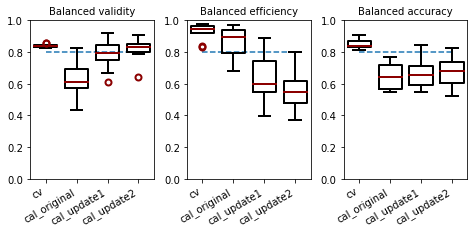

In [18]:
plt = boxplot_val_eff_acc_quer(
    evaluation_dfs=evaluation_dfs,
    measures=evaluation_measures,
    significance_level=significance_level,
    map_labels=True)

### Scatter plots to illustrate differences between strategies for individual endpoints

Format data for correct input into plotting function

In [19]:
datasets, evaluation_dfs_per_dataset = format_dataset_dict(endpoint_dict, evaluation_dfs, strategies)

Create a scatter plot showing evaluation for individual endpoints

/home/andrea/Documents/chem_bio_models/CPrecalibration_manuscript_SI/code/continuous_calibration_helper_functions.py:885: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[xax, yax].set_xticklabels(labels)#, rotation=30) #, ha="right")
/home/andrea/Documents/chem_bio_models/CPrecalibration_manuscript_SI/code/continuous_calibration_helper_functions.py:885: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[xax, yax].set_xticklabels(labels)#, rotation=30) #, ha="right")
/home/andrea/Documents/chem_bio_models/CPrecalibration_manuscript_SI/code/continuous_calibration_helper_functions.py:885: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[xax, yax].set_xticklabels(labels)#, rotation=30) #, ha="right")
/home/andrea/Documents/chem_bio_models/CPrecalibration_manuscript_SI/code/continuous_calibration_helper_functions.py:885: UserWarning: FixedFormatter should only be used together with FixedLocator
  

<Figure size 432x288 with 0 Axes>

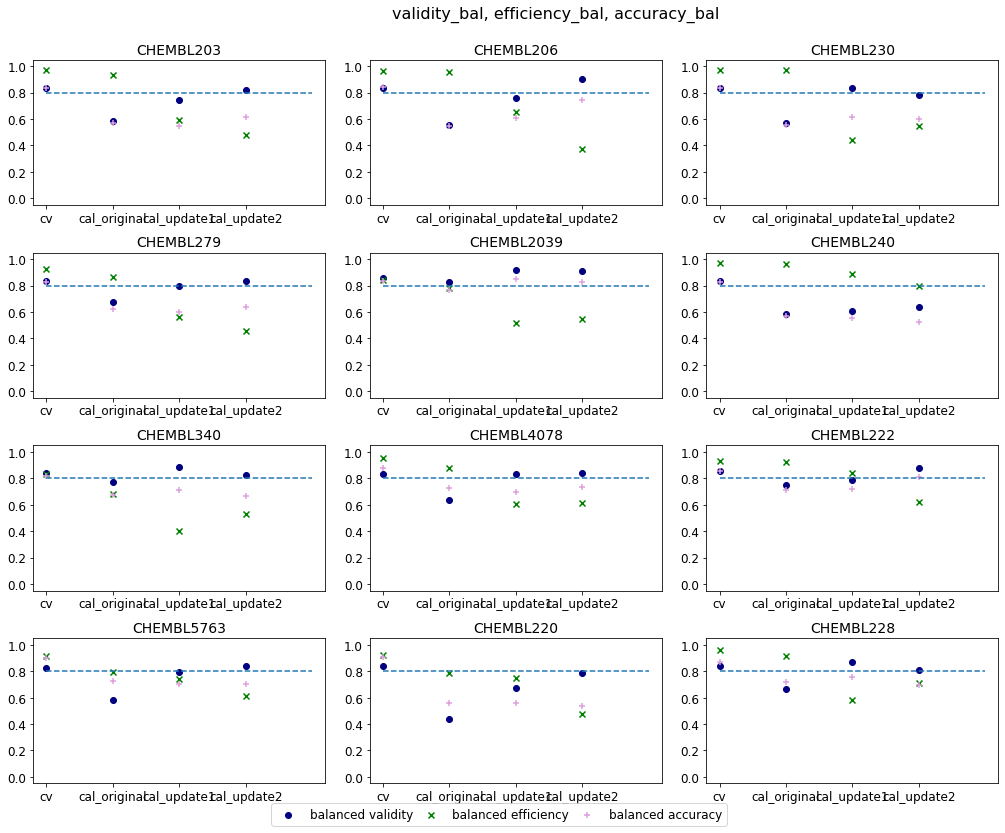

In [20]:
scatter_plt, lgd = draw_scatter_plot_more_datasets(
    evaluation_dfs_per_dataset=evaluation_dfs_per_dataset,
    datasets=datasets,
    evaluation_measures=evaluation_measures,
    colours=("navy", "green", "plum"),
    figsize=(30, 40),
    significance_level=0.2,
)